In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
import matplotlib as mpl
import seaborn as sns

In [2]:
def getdata(path):
    """Load data from file path
    
    Parameters:
    ----------
    path: str
        absolute file path (.loom).

    Returns:
    -------
    adata: scanpy.adata
        scanpy adata object
    """
    adata = sc.read_loom(path, var_names = 'var_names', obs_names = 'obs_names')
    return(adata)

def subsetdata(adata, quality='high', platform ='10X', doublets='no'):
    """subset data by cell quality, platform and non_doublets
    
    Parameters:
    ----------
    adata: scanpy.adata
        scanpy adata object
    quality: str
        'high' or 'low'
    platform: str
        '10X' for children, 'plate' for adult
    doublets: str
        'yes' or 'no'

    Returns:
    -------
    temp: scanny.adata
        scanpy adata object
    """
    temp = adata[(adata.obs.cell_quality == quality) & 
                 (adata.obs.platform == platform) & 
                 (adata.obs.doublets == doublets),].copy()
    return(temp)

def normalizedata(adata, log1p=True):
    """normalize the dataset
    
    Parameters:
    ----------
    adata: scanpy.adata
        scanpy adata object

    Returns:
    -------
    adata: scanpy.adata
        scanpy adata object
    """
    sc.pp.normalize_total(adata, target_sum=1e6)
    if log1p == True:
        sc.pp.log1p(adata, base=2)
    return(adata)

def removegenes(adata):
    """remove human HLA genes from the dataset 
    Parameters:
    ----------
    adata: scanpy.adata
        scanpy adata object

    Returns:
    -------
    temp: scanpy.adata
        scanpy adata object
    """

    IGKV = [x for x in adata.var_names if x.startswith('IGKV')]
    IGHV = [x for x in adata.var_names if x.startswith('IGHV')]
    IGLV = [x for x in adata.var_names if x.startswith('IGLV')]
    IGLC = [x for x in adata.var_names if x.startswith('IGLC')]
    IGLL = [x for x in adata.var_names if x.startswith('IGLL')]
    IGKC = [x for x in adata.var_names if x.startswith('IGKC')]
    IGHC = [x for x in adata.var_names if x.startswith('IGHC')]
    TRAV = [x for x in adata.var_names if x.startswith('TRAV')]
    TRBV = [x for x in adata.var_names if x.startswith('TRBV')]
    
    #try removing IGHG genes and MZB1 and JCHAIN
#     IGHG = [x for x in adata.var_names if x.startswith('IGHG')]
    exclude = IGKV + IGHV + IGLV + IGLC + IGLL + IGKC + IGHC + TRAV + TRBV 
    gene = [x for x in adata.var_names if x not in exclude]
    temp = adata[:,gene].copy()
    return(temp)

def remove2genes(adata):
    gene = [gene for gene in adata.var_names if gene not in ['IGHG1', 'MZB']]
    temp = adata[:, gene].copy()
    return temp

In [3]:
def frac_df(adata, cell_subtype_new, cell_type_new):     
    temp = adata[(adata.obs[cell_subtype_new] != 'unknown') & (adata.obs[cell_subtype_new] != 'doublets')].copy()
    temp = temp[(temp.obs['ID'] != '1_075_01') & (temp.obs['ID'] != '6_029_01')]
    cell_subtypes = temp.obs[cell_subtype_new].unique().tolist()
    IDs = {cst: list(temp[temp.obs[cell_subtype_new] == cst].obs['ID'].unique()) for cst in cell_subtypes}
    cds = ['Healthy', 'dengue', 'DWS', 'S_dengue']

    df = pd.DataFrame()
    fra_ct, cd, cst, patient = [], [], [], []

    for csti, ID in IDs.items():
        temp_cst = temp[temp.obs[cell_subtype_new] == csti]
        ct = temp_cst.obs[cell_type_new].unique()[0]
        for IDi in ID:
            cdi = temp_cst[temp_cst.obs['ID'] == IDi].obs['Condition'].unique()[0]
            cell_cst = temp_cst[temp_cst.obs['ID'] == IDi].obs.shape[0]
            total_ct = temp[(temp.obs['ID'] == IDi) & (temp.obs[cell_type_new] == ct)].obs.shape[0]
           
            if total_ct == 0:
                continue
            cd.append(cdi)
            cst.append(csti)
            patient.append(IDi)
            fra_ct.append(cell_cst / total_ct * 100)
            
    df['cst'] = cst
    df['Condition'] = cd
    df['ID'] = patient
    df['fra_ct'] = fra_ct
    
    df['Condition'].replace({'dengue': 'Dengue/DWS',
                            'DWS': 'Dengue/DWS',
                            'S_dengue': 'Severe dengue'},
                            inplace=True)
    df.set_index('cst', inplace=True)
    
    return df

def cell_abundance(df, cst_order, path, filetype):    
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    fig, ax = plt.subplots(figsize=[len(cst_order)*1.5, 10])
    cmap = sns.color_palette('Set2', 4)
    palette = [cmap[0], cmap[1], cmap[3]]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}
    }

    df_show = df[df['cst'].isin(cst_order)]
    df_show = df_show.set_index('cst').loc[cst_order].reset_index()
    sns.boxplot(data = df_show, 
                x = 'cst', y = 'fra_ct', hue='Condition', 
                hue_order=['Healthy', 'Dengue/DWS', 'Severe dengue'], 
                palette=palette, width=0.8, ax=ax, showfliers=False, **PROPS)
    sns.stripplot(data = df_show, 
                  x = 'cst', y = 'fra_ct', hue='Condition', 
                  hue_order=['Healthy', 'Dengue/DWS', 'Severe dengue'], 
                  palette=palette, s=7, ax=ax, edgecolor='white', linewidth=1, dodge=True)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Fraction of cells (%)')
    ax.set_xlabel(None)
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45)
    fig.tight_layout()

    if filetype is not False:
        name = 'cell_abundance' + filetype
        fig.savefig(os.path.join(path, name), bbox_inches='tight')
        
    return {'figure': fig, 'ax': ax}

In [4]:
def reorg_type_luca(adata): 
    
    adata.obs['cell_subtype_luca'].replace({
    'XCL_high NK cells': 'unknown',
    'XCL_low NK cells': 'unknown',
    'Uknown T cell': 'unknown',
    'CD4+ T cells': 'unknown',
    'CD8+ naive/memory T cells': 'unknown',
    'CD8+ effector T cells': 'unknown',
    
    'CD4 T memory': 'CD4+ memory T cells',
    'CD4 T naive': 'CD4+ naive T cells',
    'CD8 T Naive': 'CD8+ naive T cells',
    'CD8 T effector memory': 'CD8+ effector memory T cells',
    'MAIT': 'MAIT',
    'exhausted CD8 T cell': 'CD8+ exhausted T cells', 
    'Treg': 'Tregs', 
    
    'CD56 Bright': 'XCL high NK cells',
    'NK Dim': 'XCL low NK cells',
    'Proliferating NK': 'proliferating NK cells',
    }, inplace=True)

    adata.obs['cell_type_luca'] = adata.obs['cell_type_new']
#     adata.obs['cell_type_luca'].cat.add_categories(['unknown'], inplace = True)

    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'unknown', 'cell_type_luca'] = 'unknown'

    adata.obs['cell_type_luca'].cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
    adata.obs.loc[((adata.obs['cell_subtype_luca'] == 'CD4+ memory T cells') |
                   (adata.obs['cell_subtype_luca'] == 'CD4+ naive T cells') |
                   (adata.obs['cell_subtype_luca'] == 'CD8+ naive T cells') |
                   (adata.obs['cell_subtype_luca'] == 'CD8+ effector memory T cells') | 
                   (adata.obs['cell_subtype_luca'] == 'CD8+ exhausted T cells') | 
                   (adata.obs['cell_subtype_luca'] == 'MAIT') | 
                   (adata.obs['cell_subtype_luca'] == 'Tregs')), 'cell_type_luca'] = 'T cells'

    adata.obs.loc[((adata.obs['cell_subtype_luca'] == 'XCL low NK cells') |
                   (adata.obs['cell_subtype_luca'] == 'XCL high NK cells') |
                   (adata.obs['cell_subtype_luca'] == 'proliferating NK cells')), 'cell_type_luca'] = 'NK cells'

    adata.obs.loc[adata.obs['cell_type_luca'] == 'B_cells', 'cell_type_luca'] = 'B cells'

    adata.obs['cell_type_luca'].cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)
    
def reorg_subtype_luca(adata): 
    adata.obs['cell_subtype_luca'].cat.add_categories(['proliferating plasmablasts', 
                                                   'non-proliferating plasmablasts', 
                                                   'non-classical monocytes',
                                                   'intermediate monocytes',
                                                   'cytotoxic NK cells',
                                                   'signaling NK cells',
                                              ], inplace = True)

    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'cycling Plasmablasts', 
              'cell_subtype_luca'] = 'proliferating plasmablasts'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'non_cycling Plasmablasts', 
              'cell_subtype_luca'] = 'non-proliferating plasmablasts' 
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'non_classical monocytes', 
              'cell_subtype_luca'] = 'non-classical monocytes'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'macrophages', 
              'cell_subtype_luca'] = 'intermediate monocytes'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'XCL low NK cells', 
                  'cell_subtype_luca'] = 'cytotoxic NK cells'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'XCL high NK cells', 
                  'cell_subtype_luca'] = 'signaling NK cells'

    adata.obs['cell_subtype_luca'].cat.remove_categories(['cycling Plasmablasts', 
                                                      'non_cycling Plasmablasts',
                                                      'non_classical monocytes',
                                                      'macrophages',
                                                      'XCL low NK cells',
                                                      'XCL high NK cells'
                                                 ], inplace = True)

In [5]:
# adjust cell types and subtypes according to Luca's annotation, including NK and T cells 
# save the result in 'cell_subtype_luca' and 'cell_type_luca'

adata = sc.read_h5ad('/home/yike/phd/dengue/data/adataLG.h5ad')
adata.obs['cell_subtype_luca_T'] = adata.obs['cell_subtype_luca']
reorg_type_luca(adata)
reorg_subtype_luca(adata)

<ipython-input-4-9ab0052b0c7c>:29: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca'].cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
<ipython-input-4-9ab0052b0c7c>:44: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca'].cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)
<ipython-input-4-9ab0052b0c7c>:47: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_subtype_luca'].cat.add_categories(['proliferating plasmablasts',
<ipy

In [7]:
# adjust cell types and subtypes according to Luca's annotation, only including T cells
# keep Zhiyuan's annotation about NK cells
# save the result in 'cell_subtype_luca_T' and 'cell_type_luca_T'

# rename cell subtype just according to Luca's T cells
adata.obs['cell_subtype_luca_T'].replace({
'CD4+ T cells': 'unknown',
'CD8+ naive/memory T cells': 'unknown',
'CD8+ effector T cells': 'unknown',

'CD4 T memory': 'CD4+ memory T cells',
'CD4 T naive': 'CD4+ naive T cells',
'CD8 T Naive': 'CD8+ naive T cells',
'CD8 T effector memory': 'CD8+ effector memory T cells',
'MAIT': 'MAIT',
'exhausted CD8 T cell': 'CD8+ exhausted T cells', 
'Treg': 'Tregs', 
}, inplace=True)

# start to annotate cell types
adata.obs['cell_type_luca_T'] = adata.obs['cell_type_new']

adata.obs['cell_type_luca_T'].cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
adata.obs.loc[adata.obs['cell_subtype_luca_T'].isin(['CD4+ memory T cells','CD4+ naive T cells', 
                                                     'CD8+ naive T cells',
                                                     'CD8+ effector memory T cells', 'CD8+ exhausted T cells',
                                                     'Tregs', 'MAIT']), 'cell_type_luca_T'] = 'T cells'

adata.obs.loc[adata.obs['cell_subtype_new'].isin(['XCL_low NK cells', 
                                                 'XCL_high NK cells']), 'cell_type_luca_T'] = 'NK cells'

adata.obs.loc[adata.obs['cell_type_luca_T'] == 'B_cells', 'cell_type_luca_T'] = 'B cells'

adata.obs['cell_type_luca_T'].cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)

# start to annotate cell subtypes
adata.obs['cell_subtype_luca_T'].cat.add_categories(['proliferating plasmablasts', 
                                               'non-proliferating plasmablasts', 
                                               'non-classical monocytes',
                                               'intermediate monocytes',
                                               'cytotoxic NK cells',
                                               'signaling NK cells',
                                          ], inplace = True)

adata.obs.loc[adata.obs['cell_subtype_luca_T'] == 'cycling Plasmablasts', 
          'cell_subtype_luca_T'] = 'proliferating plasmablasts'
adata.obs.loc[adata.obs['cell_subtype_luca_T'] == 'non_cycling Plasmablasts', 
          'cell_subtype_luca_T'] = 'non-proliferating plasmablasts' 
adata.obs.loc[adata.obs['cell_subtype_luca_T'] == 'non_classical monocytes', 
          'cell_subtype_luca_T'] = 'non-classical monocytes'
adata.obs.loc[adata.obs['cell_subtype_luca_T'] == 'macrophages', 
          'cell_subtype_luca_T'] = 'intermediate monocytes'

# becareful when annotating NK cells according to Zhiyuan's annotation
adata.obs.loc[adata.obs['cell_subtype_new'] == 'XCL_low NK cells', 
              'cell_subtype_luca_T'] = 'cytotoxic NK cells'
adata.obs.loc[adata.obs['cell_subtype_new'] == 'XCL_high NK cells', 
              'cell_subtype_luca_T'] = 'signaling NK cells'

# remove unuseful categories
adata.obs.loc[adata.obs['cell_subtype_luca_T'].isin(['Uknown T cell', 'NK Dim', 
                                                     'CD56 Bright', 'Proliferating NK']), 
          'cell_subtype_luca_T'] = 'unknown'

adata.obs['cell_subtype_luca_T'].cat.remove_categories([
                                                 'cycling Plasmablasts', 
                                                  'non_cycling Plasmablasts',
                                                  'non_classical monocytes',
                                                  'macrophages',
                                                  'XCL_low NK cells',
                                                  'XCL_high NK cells',
                                                   'Uknown T cell', 
                                                        'NK Dim', 
                                                        'CD56 Bright', 
                                                        'Proliferating NK'
                                                        
                                             ], inplace = True)

# reannotate T cell type and cell subtypes just to make T cell subtype are large enough

for cst in ['CD4+ memory T cells','CD4+ naive T cells', 
             'CD8+ naive T cells',
             'CD8+ effector memory T cells', 'CD8+ exhausted T cells',
             'Tregs', 'MAIT']:
    adata.obs.loc[adata.obs['cell_subtype_luca'] == cst, 
              'cell_subtype_luca_T'] = cst
    
adata.obs.loc[adata.obs['cell_subtype_luca_T'].isin(['CD4+ memory T cells','CD4+ naive T cells', 
             'CD8+ naive T cells',
             'CD8+ effector memory T cells', 'CD8+ exhausted T cells',
             'Tregs', 'MAIT']), 
              'cell_type_luca_T'] = 'T cells'

<ipython-input-7-6306248c3951>:23: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca_T'].cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
<ipython-input-7-6306248c3951>:34: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca_T'].cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)
<ipython-input-7-6306248c3951>:37: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_subtype_luca_T'].cat.add_categories(['proliferating plasmablasts'

In [8]:
# adjust column names to macth previous codes
# cell_type_new -> cell_type_zhiyuan
# cell_subtype_new -> cell_type_zhiyuan

#cell_type_luca_T -> cell_type_new
#cell_subtype_luca_T -> cell_subtype_new

adata.obs = adata.obs.rename(columns = {
    'cell_type_new': 'cell_type_zhiyuan',
    'cell_subtype_new': 'cell_subtype_zhiyuan',

    'cell_type_luca_T': 'cell_type_new',
    'cell_subtype_luca_T': 'cell_subtype_new',
}
                            )

In [19]:
adata.obs.loc[adata.obs['cell_type_new'] == 'plasmacytoid DCs', 'cell_subtype_new'] = 'plasmacytoid DCs'

In [ ]:
adata.write('/home/yike/phd/dengue/data/mergedata_luca_NKT_202206.h5ad')

In [7]:
def reorg_cell_luca(adata): 
    
    adata.obs['cell_subtype_luca'].replace({
    'XCL_high NK cells': 'unknown',
    'XCL_low NK cells': 'unknown',
    'Uknown T cell': 'unknown',
    'CD4+ T cells': 'unknown',
    'CD8+ naive/memory T cells': 'unknown',
    'CD8+ effector T cells': 'unknown',
    
    'CD4 T memory': 'CD4+ memory T cells',
    'CD4 T naive': 'CD4+ naive T cells',
    'CD8 T Naive': 'CD8+ naive T cells',
    'CD8 T effector memory': 'CD8+ effector/memory T cells',
    'MAIT': 'MAIT',
    'exhausted CD8 T cell': 'CD8+ exhausted T cells', 
    'Treg': 'Tregs', 
    
    'CD56 Bright': 'XCL high NK cells',
    'NK Dim': 'XCL low NK cells',
    'Proliferating NK': 'proliferating NK cells',
    }, inplace=True)

    adata.obs['cell_type_luca'] = adata.obs['cell_type_new']
#     adata.obs['cell_type_luca'].cat.add_categories(['unknown'], inplace = True)

    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'unknown', 'cell_type_luca'] = 'unknown'

    adata.obs['cell_type_luca'].cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
    adata.obs.loc[((adata.obs['cell_subtype_luca'] == 'CD4+ memory T cells') |
                   (adata.obs['cell_subtype_luca'] == 'CD4+ naive T cells') |
                   (adata.obs['cell_subtype_luca'] == 'CD8+ naive T cells') |
                   (adata.obs['cell_subtype_luca'] == 'CD8+ effector/memory T cells') | 
                   (adata.obs['cell_subtype_luca'] == 'CD8+ exhausted T cells') | 
                   (adata.obs['cell_subtype_luca'] == 'MAIT') | 
                   (adata.obs['cell_subtype_luca'] == 'Tregs')), 'cell_type_luca'] = 'T cells'

    adata.obs.loc[((adata.obs['cell_subtype_luca'] == 'XCL low NK cells') |
                   (adata.obs['cell_subtype_luca'] == 'XCL high NK cells') |
                   (adata.obs['cell_subtype_luca'] == 'proliferating NK cells')), 'cell_type_luca'] = 'NK cells'

    adata.obs.loc[adata.obs['cell_type_luca'] == 'B_cells', 'cell_type_luca'] = 'B cells'

    adata.obs['cell_type_luca'].cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)
    
def reorg_cell_luca1(adata):     
    adata = adata[adata.obs['cell_type_luca'] != 'unknown']
    group_order_primary = ['B cells', 'Plasmablasts', 'T cells', 'NK cells', 
                           'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 
                           'megakaryocytes']
    adata.obs['cell_type_luca'].cat.reorder_categories(group_order_primary, inplace = True)

def reorg_cell_luca2(adata): 
    adata.obs['cell_subtype_luca'].cat.add_categories(['proliferating plasmablasts', 
                                                   'non-proliferating plasmablasts', 
                                                   'non-classical monocytes',
                                                   'intermediate monocytes',
                                                   'cytotoxic NK cells',
                                                   'signaling NK cells',
                                              ], inplace = True)

    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'cycling Plasmablasts', 
              'cell_subtype_luca'] = 'proliferating plasmablasts'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'non_cycling Plasmablasts', 
              'cell_subtype_luca'] = 'non-proliferating plasmablasts' 
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'non_classical monocytes', 
              'cell_subtype_luca'] = 'non-classical monocytes'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'macrophages', 
              'cell_subtype_luca'] = 'intermediate monocytes'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'XCL low NK cells', 
                  'cell_subtype_luca'] = 'cytotoxic NK cells'
    adata.obs.loc[adata.obs['cell_subtype_luca'] == 'XCL high NK cells', 
                  'cell_subtype_luca'] = 'signaling NK cells'

    adata.obs['cell_subtype_luca'].cat.remove_categories(['cycling Plasmablasts', 
                                                      'non_cycling Plasmablasts',
                                                      'non_classical monocytes',
                                                      'macrophages',
                                                      'XCL low NK cells',
                                                      'XCL high NK cells'
                                                 ], inplace = True)
def reorg_cell_luca3(adata): 
    adata = adata[adata.obs['cell_subtype_luca'] != 'unknown']
    
    group_order_secondary = [
        'classical monocytes',
        'non-classical monocytes',
        'intermediate monocytes',

        'cytotoxic NK cells',
        'signaling NK cells',
        'proliferating NK cells',

        'non-proliferating plasmablasts',
        'proliferating plasmablasts',

        'naive B cells',
        'memory B cells',
        'activated B cells',

        'CD4+ naive T cells',
        'CD4+ memory T cells',

        'CD8+ naive T cells',
        'CD8+ effector/memory T cells',
        'CD8+ exhausted T cells',
        'Tregs',
        'MAIT',

        'plasmacytoid DCs',
        'conventional DCs',

        'megakaryocytes',
    ]

    adata.obs['cell_subtype_luca'].cat.reorder_categories(group_order_secondary, inplace = True)

In [6]:
#rename and reorder some celltypes 
reorg_cell_luca(adata_kid) 

<ipython-input-5-4b2fb48ced2a>:25: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca'].cat.add_categories(['unknown'], inplace = True)
<ipython-input-5-4b2fb48ced2a>:29: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca'].cat.add_categories(['T cells', 'NK cells', 'B cells'], inplace = True)
<ipython-input-5-4b2fb48ced2a>:44: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_type_luca'].cat.remove_categories(['NK/T_cells', 'B_cells'], inplace = True)


In [7]:
reorg_cell_luca1(adata_kid) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
<ipython-input-5-4b2fb48ced2a>:51: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['cell_type_luca'].cat.reorder_categories(group_order_primary, inplace = True)


In [8]:
reorg_cell_luca2(adata_kid) 

<ipython-input-5-4b2fb48ced2a>:54: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_subtype_luca'].cat.add_categories(['proliferating plasmablasts',
<ipython-input-5-4b2fb48ced2a>:75: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['cell_subtype_luca'].cat.remove_categories(['cycling Plasmablasts',


In [13]:
reorg_cell_luca3(adata_kid) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
<ipython-input-12-4b2fb48ced2a>:116: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['cell_subtype_luca'].cat.reorder_categories(group_order_secondary, inplace = True)


In [16]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [17]:
cluster (adata_kid)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:381: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:383: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:386: PerformanceWarning: DataF

In [30]:
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [54]:
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ naive T cells', 'CD4+ memory T cells', 'CD8+ naive T cells', 'CD8+ effector/memory T cells', 'CD8+ exhausted T cells', 'Tregs', 'MAIT', 'signaling NK cells', 'cytotoxic NK cells', 'proliferating NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.4392156862745098, 0.5019607843137255, 0.5647058823529412),
 (0.0, 0.0, 0.5019607843137255),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.7490196078431373, 1.0),
 (0.0, 1.0, 1.0),
 (0.37254901960784315, 0.6196078431372549, 0.6274509803921569),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (1.0, 0.0, 1.0),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [53]:
def load_ct_palette():    
    ct_colors = {'B cells': (0.8352941176470589, 0.3686274509803922, 0.0),
                 'Plasmablasts': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
                 'T cells': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
                 'NK cells': (0.8, 0.47058823529411764, 0.7372549019607844),
                 'Monocytes': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
                 'conventional DCs': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
                 'plasmacytoid DCs': (0.792156862745098,0.5686274509803921, 0.3803921568627451),
                 'megakaryocytes': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)}

    return ct_colors

def load_cst_palette():
    cst_colors = {'memory B cells': (1.0, 0.0, 0.0),
                 'naive B cells': (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
                 'activated B cells': (0.5019607843137255, 0.0, 0.0),
                  
                 'proliferating plasmablasts': (1.0, 0.8941176470588236, 0.7686274509803922),
                 'non-proliferating plasmablasts': (1.0, 0.5490196078431373, 0.0),
                  
                 'CD4+ naive T cells': (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
                 'CD4+ memory T cells': (0.4392156862745098, 0.5019607843137255, 0.5647058823529412), # slategrey
                 'CD8+ naive T cells': (0.0, 0.0, 0.5019607843137255),
                 'CD8+ effector/memory T cells': (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
                 'CD8+ exhausted T cells': (0.0, 0.7490196078431373, 1.0),# indigo
                 'Tregs': (0.0, 1.0, 1.0),#cyan
                 'MAIT': (0.37254901960784315, 0.6196078431372549, 0.6274509803921569),#cadetblue
                  
                 'signaling NK cells': (0.5019607843137255, 0.0, 0.5019607843137255),
                 'cytotoxic NK cells': (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
                 'proliferating NK cells': (1.0, 0.0, 1.0),

                 'classical monocytes': (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
                 'non-classical monocytes': (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
                 'intermediate monocytes': (0.0, 0.5019607843137255, 0.0),
                  
                 'conventional DCs': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
                 'plasmacytoid DCs': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
                 'megakaryocytes': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)}
    
    return cst_colors

In [50]:
mpl.colors.to_rgba('deepskyblue')

(0.0, 0.7490196078431373, 1.0, 1.0)

In [55]:
def umap_plot(adata, path, group, color_map, title, filetype=False, annotation=False, **kwargs):
    rcParams['figure.figsize']=(7,7)
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"
    
    temp = adata[(adata.obs[group] != 'unknown') & (adata.obs[group] != 'doublets')].copy()
    
    fig, ax = plt.subplots()
    if annotation == False:
        sc.pl.umap(temp, color=group, palette = color_map, ax=ax, show=False, title = title, size=20, **kwargs)
        ax.legend(markerscale = 3, fontsize = 16, bbox_to_anchor=(1, 1), frameon = False)
    elif annotation == True:
        temp.obs['umap'] = temp.obs[group]
        ct_rep = {'B cells': 'B',
                  'Plasmablasts': 'Plasmablasts',
                  'T cells': 'T',
                  'NK cells': 'NK',
                  'Monocytes': 'Monocytes',
                  'conventional DCs': 'cDCs',
                  'plasmacytoid DCs': 'pDCs',
                  'megakaryocytes': 'mega'}
        cst_rep = {cst: str(n + 1) for cst, n in zip(cell_subtypes, range(len(cell_subtypes)))}
        temp.obs['umap'].replace([ct_rep, cst_rep][group != 'cell_type_new'], inplace=True)
        
        reorder_list = [[ct_rep[ct] for ct in cell_types], [cst_rep[cst] for cst in cell_subtypes]]
        temp.obs.umap = temp.obs.umap.astype('category')
        temp.obs.umap.cat.reorder_categories(reorder_list[group != 'cell_type_new'], 
            inplace = True)

        sc.pl.umap(temp, color='umap', palette = color_map, ax=ax, show=False, title = title, size=20,
                   legend_loc='on data', legend_fontweight = 'bold', **kwargs)
        
    if filetype is not False:
        name = 'umap_' + group +'.' + filetype
        fig.savefig(os.path.join(path, name), bbox_inches='tight')
        
    return {'xlim': ax.get_xlim(), 'ylim': ax.get_ylim()}

In [47]:
adata_kid = adata_kid[adata_kid.obs['cell_type_luca'] != 'unknown']

In [48]:
cell_types = adata_kid.obs['cell_type_luca'].cat.categories.tolist()
cell_subtypes = adata_kid.obs['cell_subtype_luca'].cat.categories.tolist()

{'xlim': (-6.872257709503174, 17.4165940284729),
 'ylim': (-8.079531359672547, 19.59471814632416)}

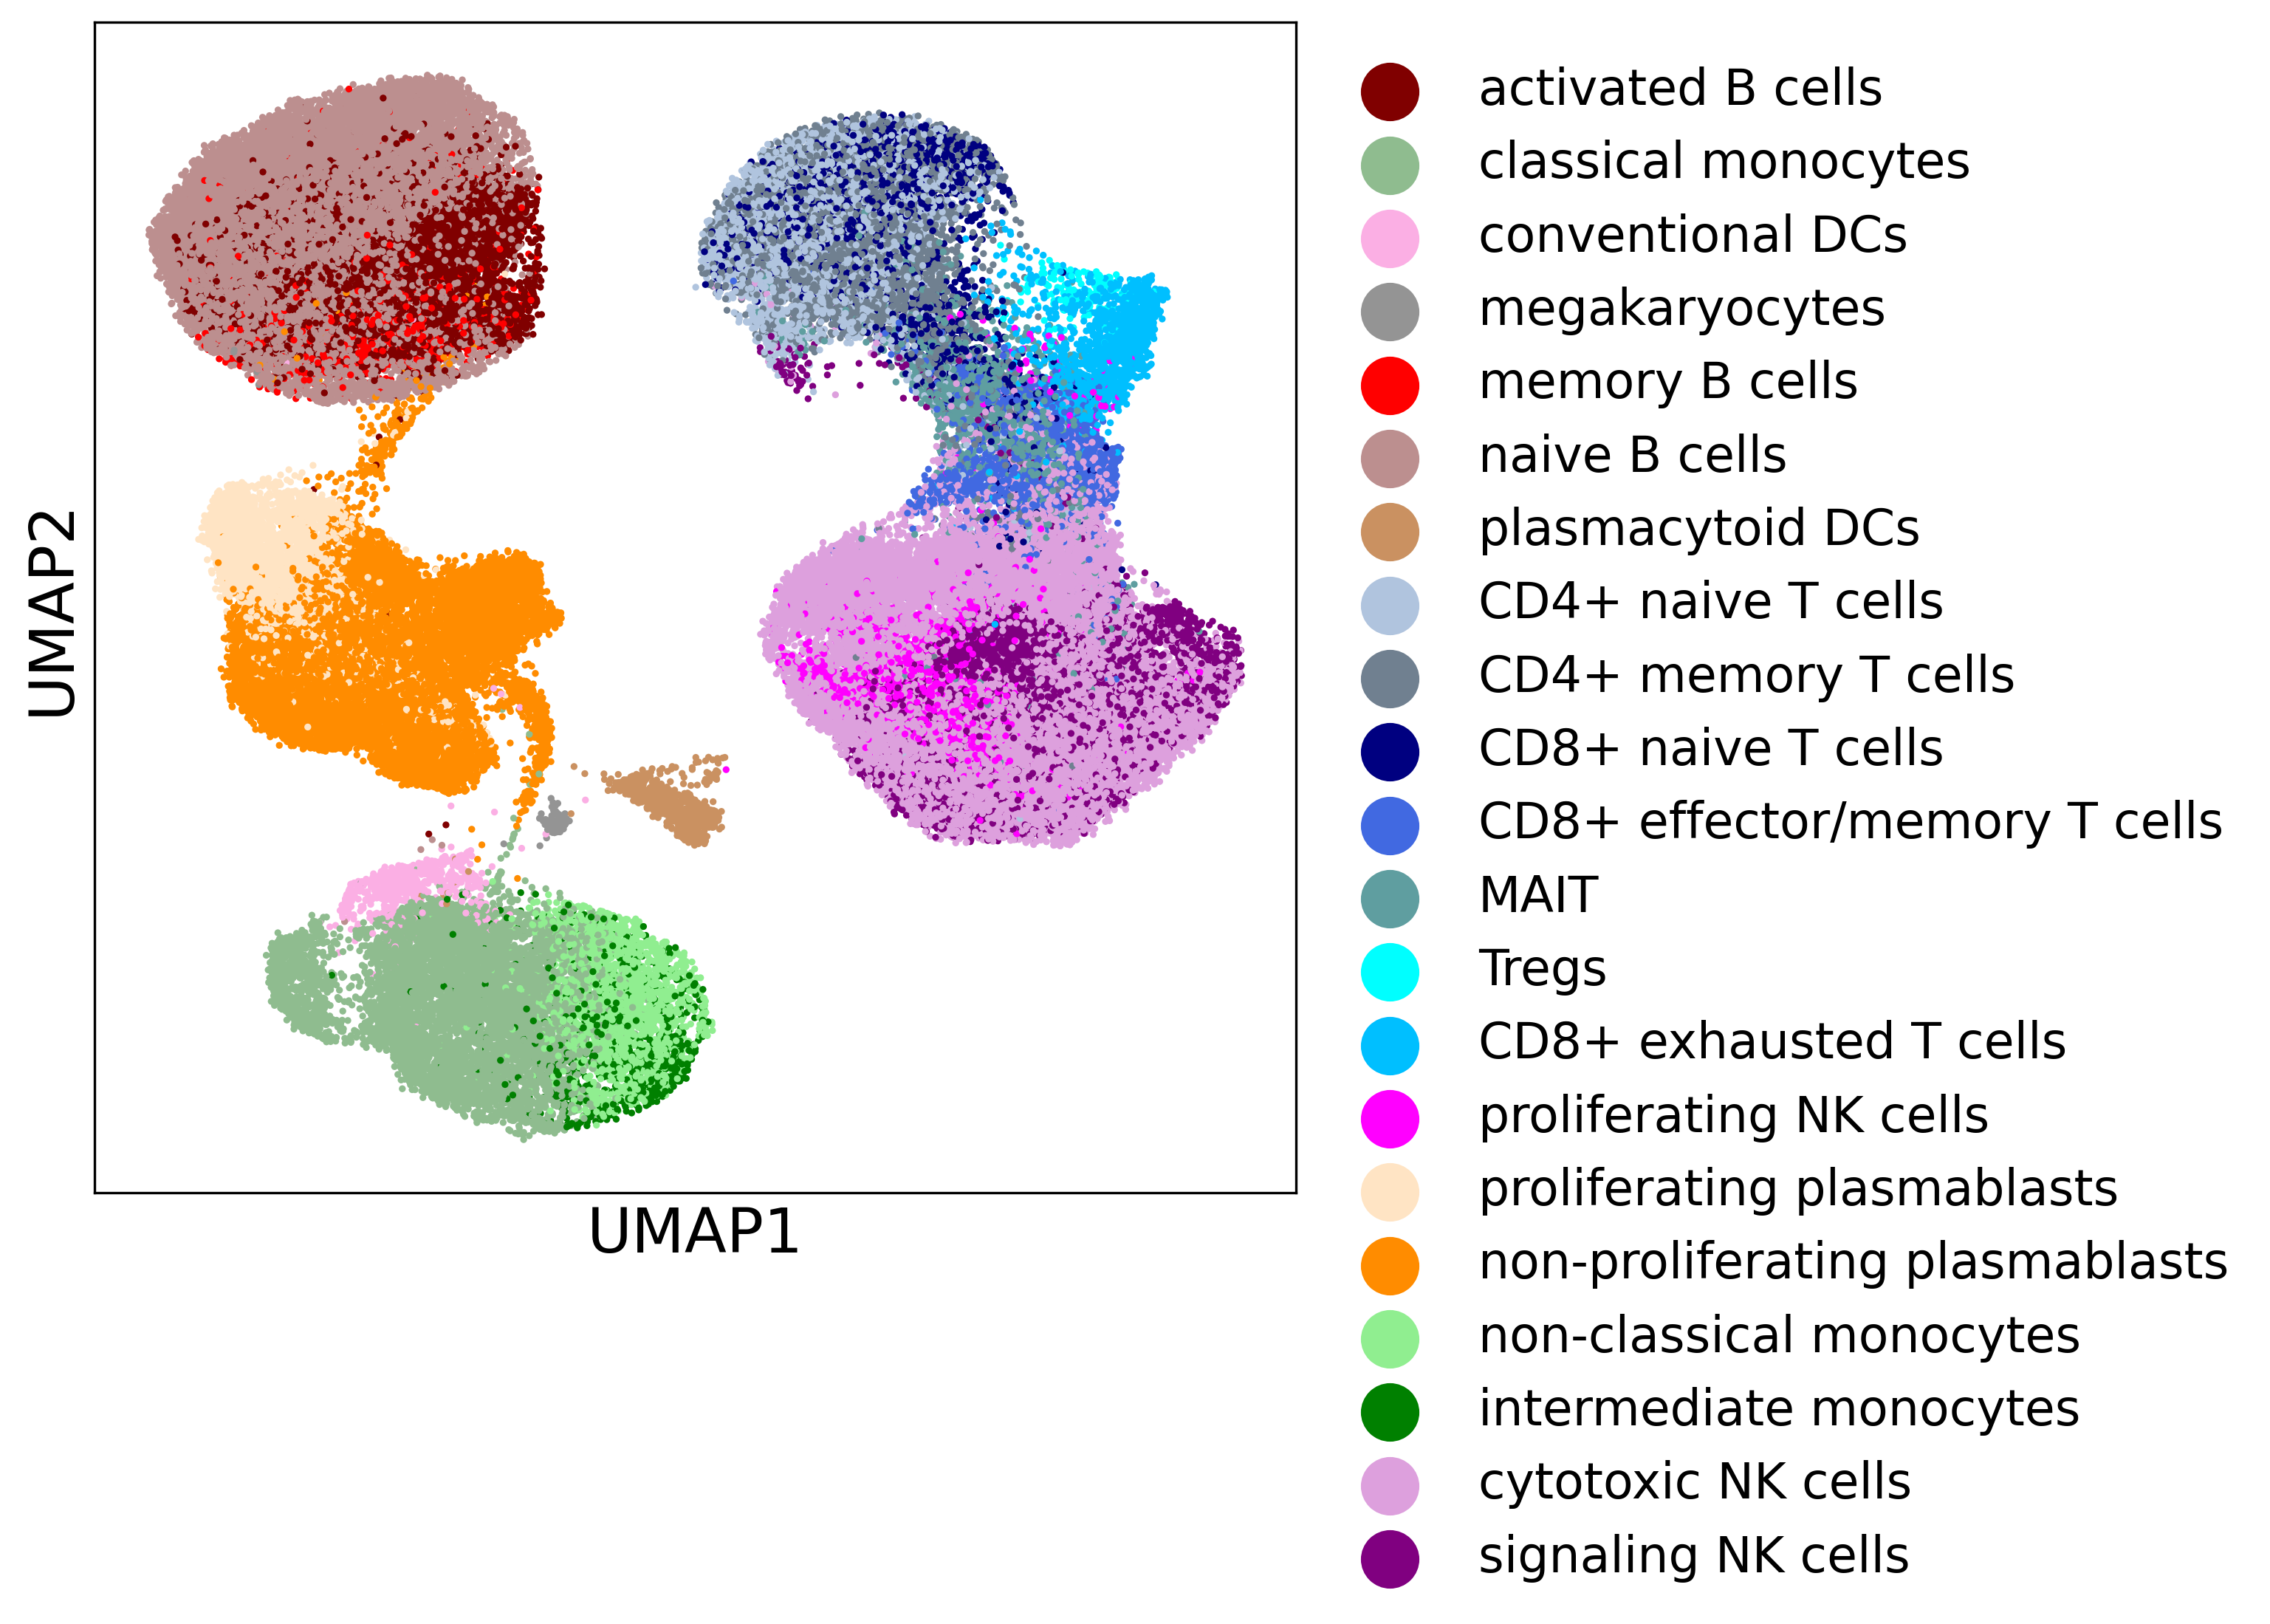

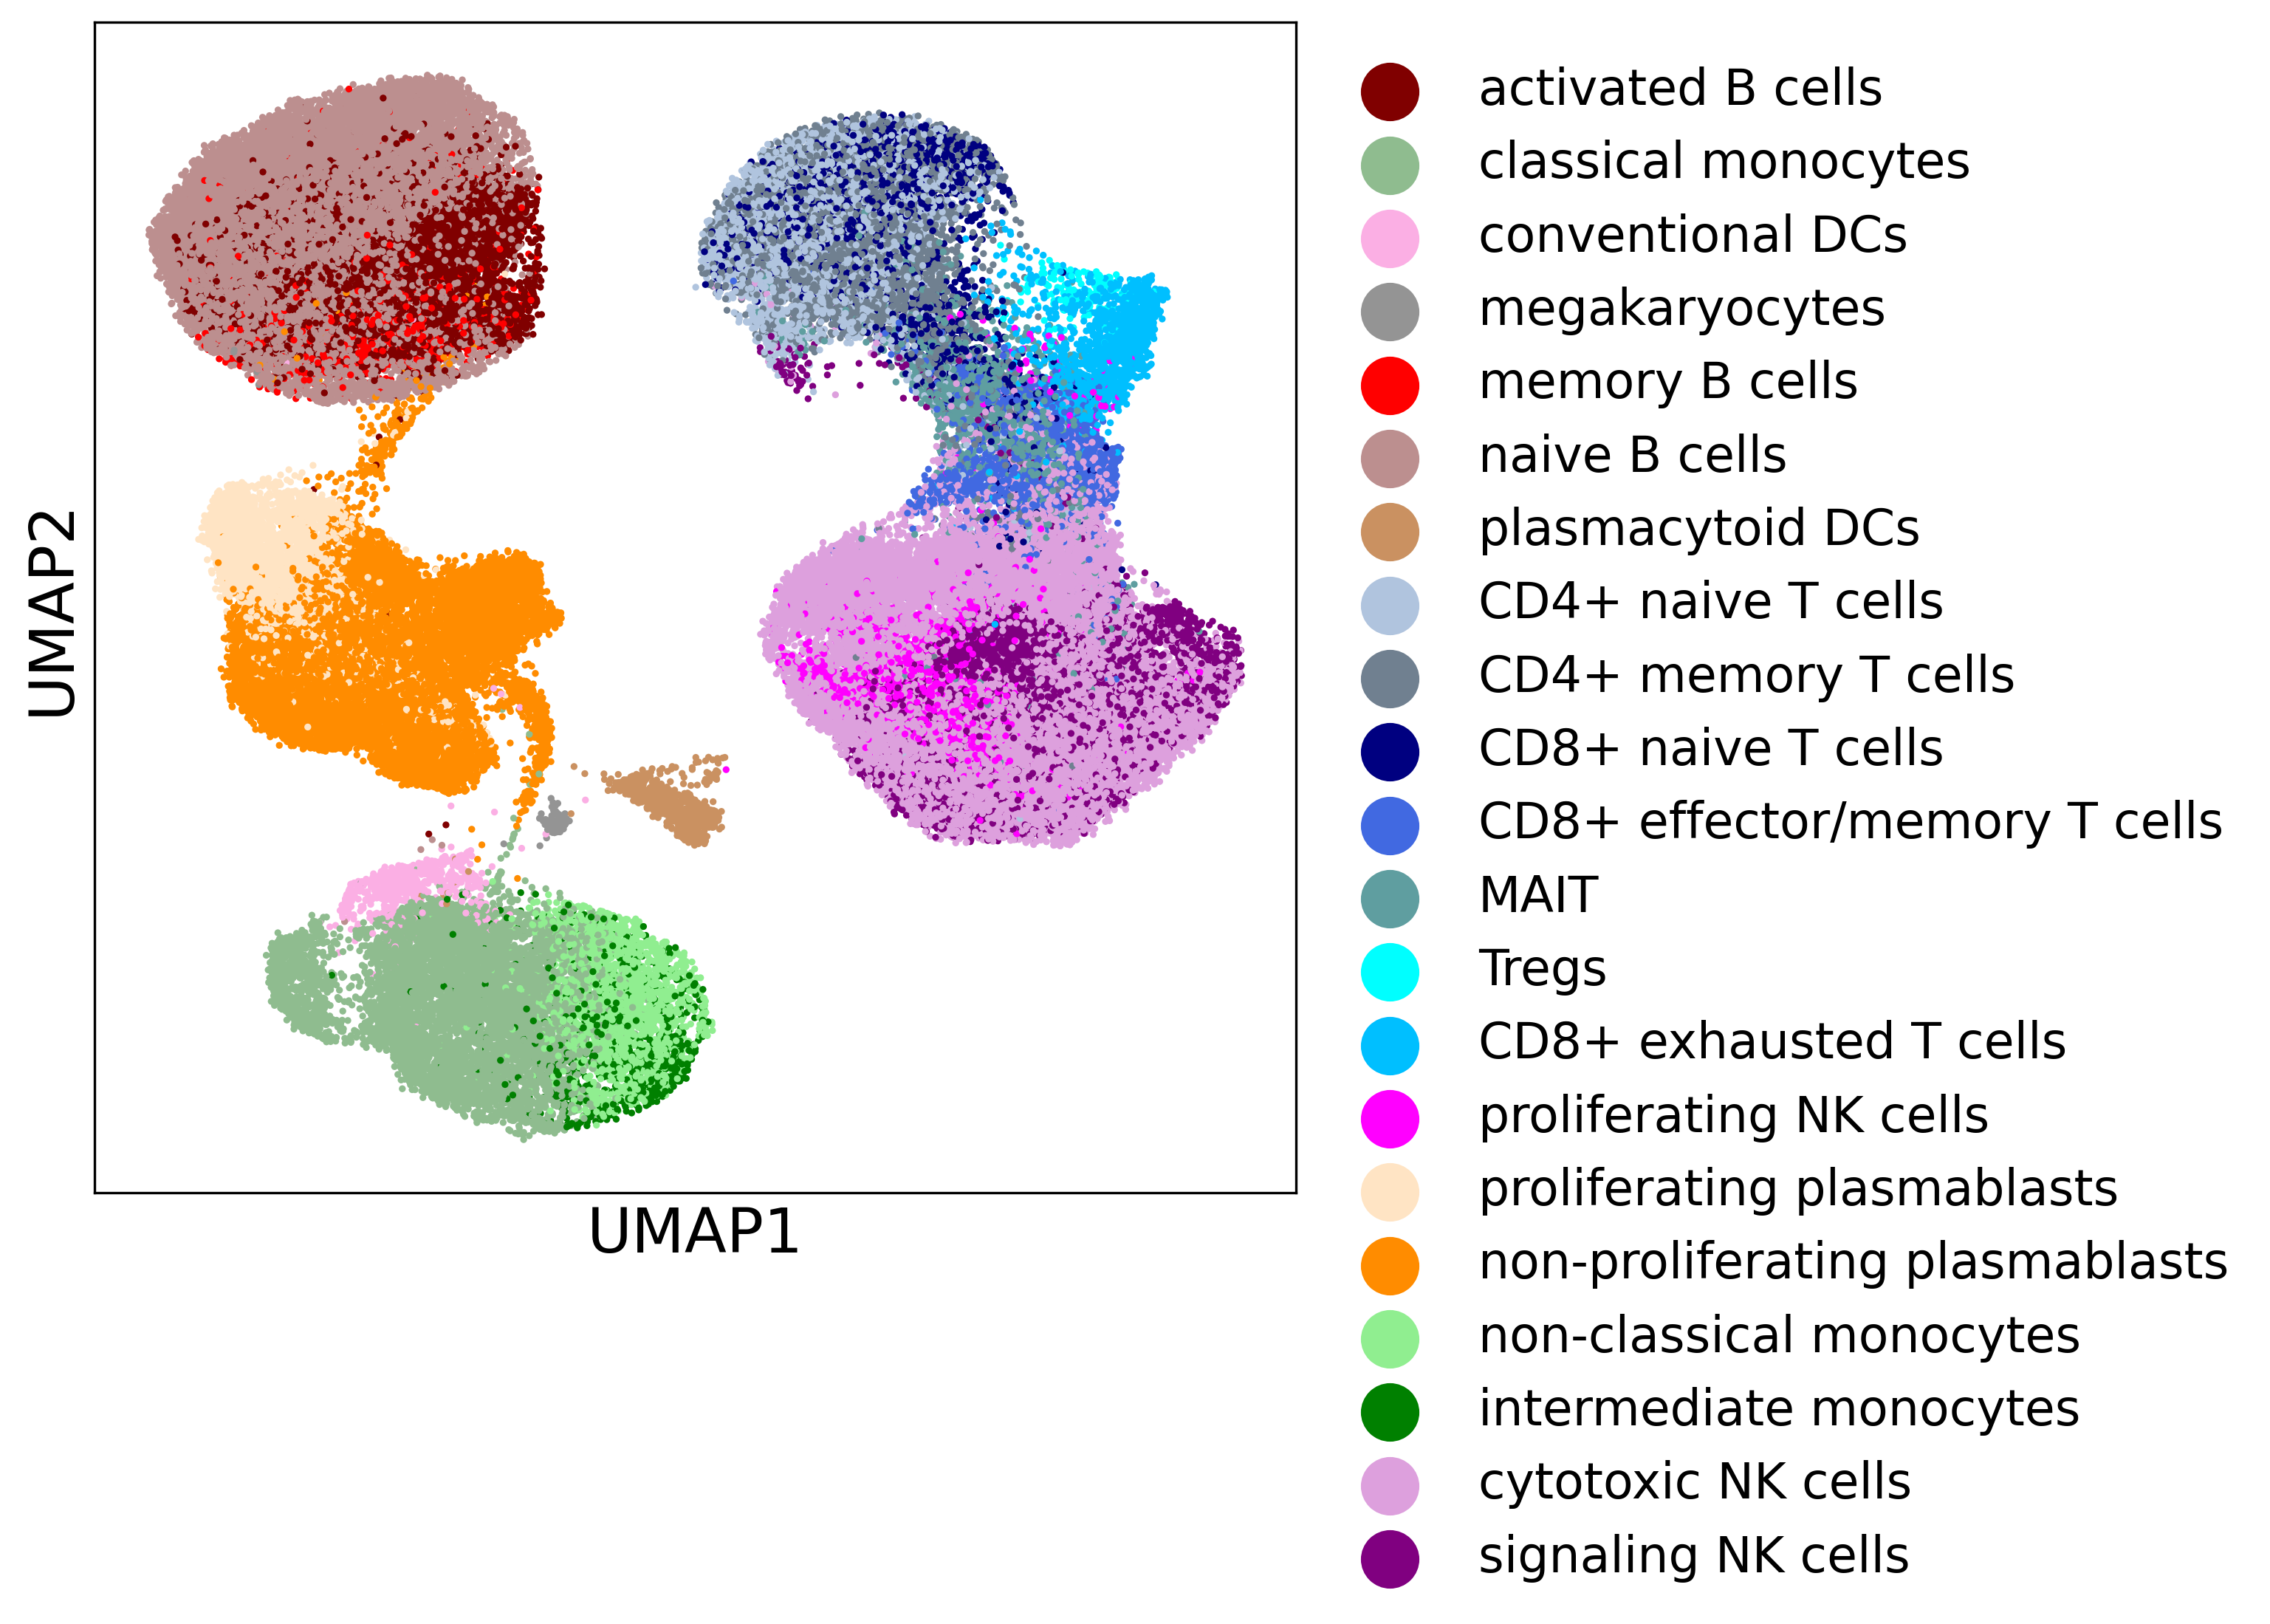

In [56]:
save_figures = '/home/yike/phd/'
#Figure 1C, umap

cmap_ct = sns.color_palette([ct_palette[ct] for ct in cell_types])
umap_plot(adata_kid, save_figures, 'cell_type_luca', cmap_ct, '', 'png')
umap_plot(adata_kid, save_figures, 'cell_type_luca', cmap_ct, '', 'pdf')

# umap_plot(adata_kid, save_figures, 'cell_type_luca', cmap_ct, '', 'ant.png', annotation=True)
# umap_plot(adata_kid, save_figures, 'cell_type_luca', cmap_ct, '', 'ant.pdf', annotation=True)

cmap_cst = sns.color_palette([cst_palette[cst] for cst in cell_subtypes])
lims = umap_plot(adata_kid, save_figures, 'cell_subtype_luca', cmap_cst, '', 'png')
umap_plot(adata_kid, save_figures, 'cell_subtype_luca', cmap_cst, '', 'pdf')

# lims = umap_plot(adata_kid, save_figures, 'cell_subtype_luca', cmap_cst, '', 'ant.png', annotation=True)
# umap_plot(adata_kid, save_figures, 'cell_subtype_luca', cmap_cst, '', 'ant.pdf', annotation=True)

In [63]:
def dotplot(adata, path, marker_genes):
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 18
    rcParams['figure.dpi'] = 300

    fig, ax = plt.subplots(figsize = (15, 7))
    axs = sc.pl.dotplot(adata_kid, marker_genes, groupby='cell_subtype_luca', cmap = 'viridis', 
                      use_raw=False, show=False, ax=ax,
                      colorbar_title = 'Mean exp\n(cpm)',
                      size_title = 'Frac of cells\n(%)')

    lims = axs['color_legend_ax'].get_xlim()
    axs['color_legend_ax'].remove()

    norm = mpl.colors.Normalize(lims[0], lims[1])
    cmap = plt.cm.get_cmap('viridis')
    axs['color_legend_ax'] = fig.add_axes([0.82, 0.5, 0.1, 0.05])
    cbar = mpl.colorbar.ColorbarBase(axs['color_legend_ax'], norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks([0, np.log2(10), np.log2(100), np.log2(1000), np.log2(10000)])
    cbar.set_ticklabels(['0', '$10$', '$10^2$', '$10^3$', '$10^4$'])
    cbar.ax.tick_params(labelsize=15)
    axs['color_legend_ax'].set_title('Mean exp\n(cpm)', fontsize=15)
    plt.show()
    
    fig.savefig(os.path.join(path, 'dotplot.png'), bbox_inches='tight')
    fig.savefig(os.path.join(path, 'dotplot.pdf'), bbox_inches='tight')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


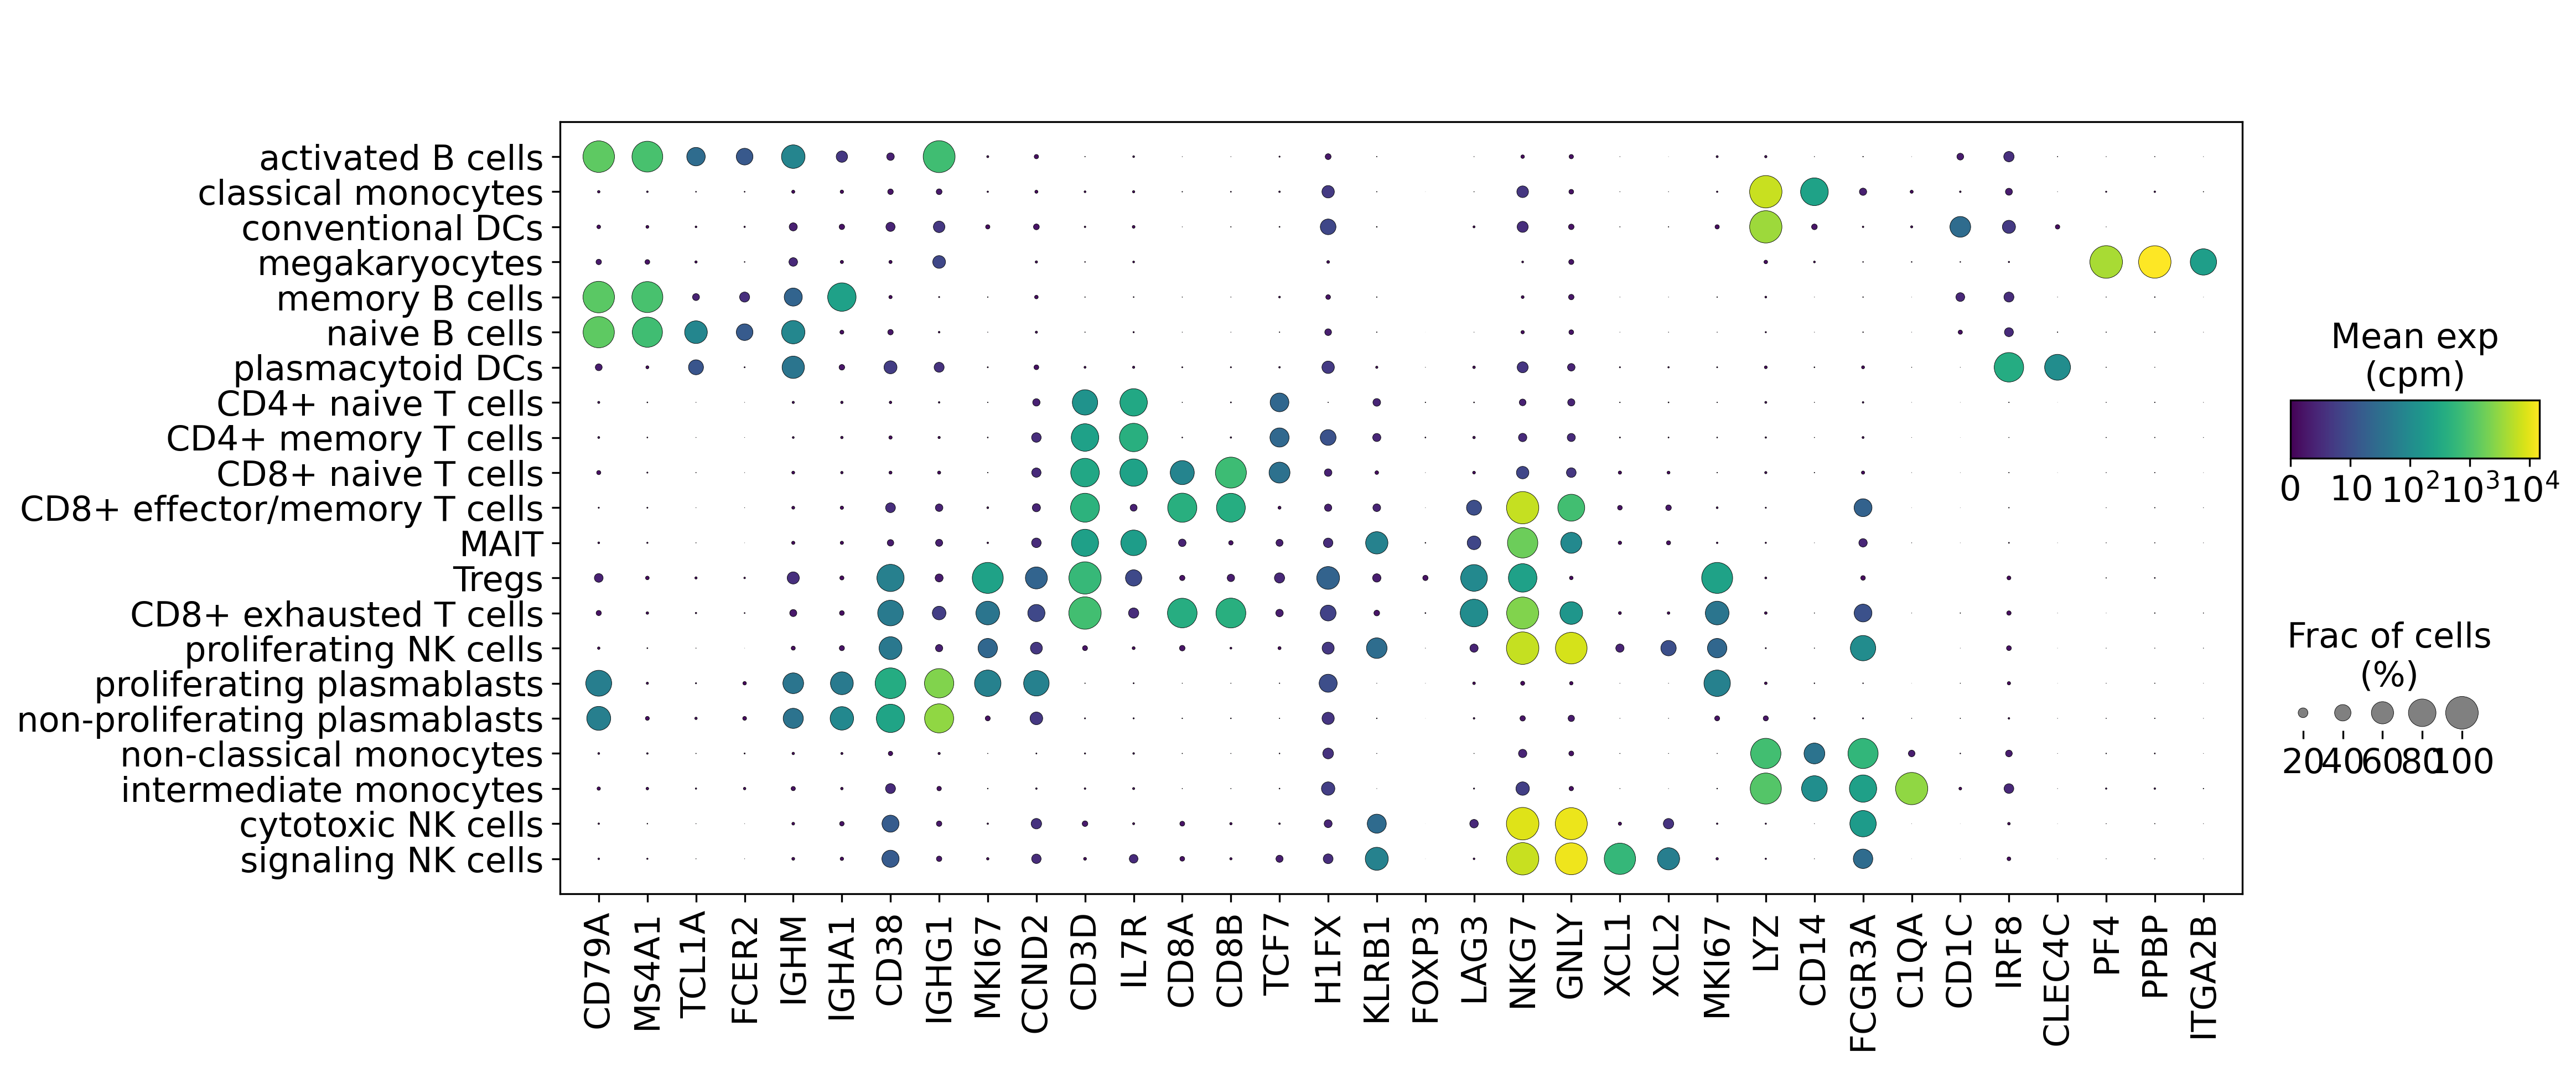

In [64]:
marker_genes = ['CD79A', 'MS4A1', 'TCL1A', 'FCER2',
                'IGHM', 'IGHA1', 'CD38', 'IGHG1', 
                'MKI67', 'CCND2', 
#                 'CD3D', 'IL7R', 'CD8A', 'CD8B', 'GZMA', #'GZMK', 
                'CD3D', 'IL7R', 'CD8A', 'CD8B','TCF7', 'H1FX', 'KLRB1', 'FOXP3', 'LAG3', 
                'NKG7', 'GNLY', 'XCL1', 'XCL2', 'MKI67',
                'LYZ', 'CD14', 'FCGR3A', 'C1QA',
                'CD1C', 'IRF8', 'CLEC4C', 
                'PF4', 'PPBP', 'ITGA2B']

dotplot(adata_kid, save_figures, marker_genes)

In [65]:
df_frac = frac_df(adata_kid, 'cell_subtype_luca', 'cell_type_luca')

order = [
        'classical monocytes',
        'non-classical monocytes',
        'intermediate monocytes',

        'cytotoxic NK cells',
        'signaling NK cells',
        'proliferating NK cells',

        'non-proliferating plasmablasts',
        'proliferating plasmablasts',

        'naive B cells',
        'memory B cells',
        'activated B cells',

        'CD4+ naive T cells',
        'CD4+ memory T cells',

        'CD8+ naive T cells',
        'CD8+ effector/memory T cells',
        'CD8+ exhausted T cells',
        'Tregs',
        'MAIT',
    
        'plasmacytoid DCs',
        'conventional DCs',
        'megakaryocytes']

df_frac = df_frac.loc[order]
df_frac.reset_index(inplace=True)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


{'figure': <Figure size 8100x3000 with 1 Axes>,
 'ax': <AxesSubplot:ylabel='Fraction of cells (%)'>}

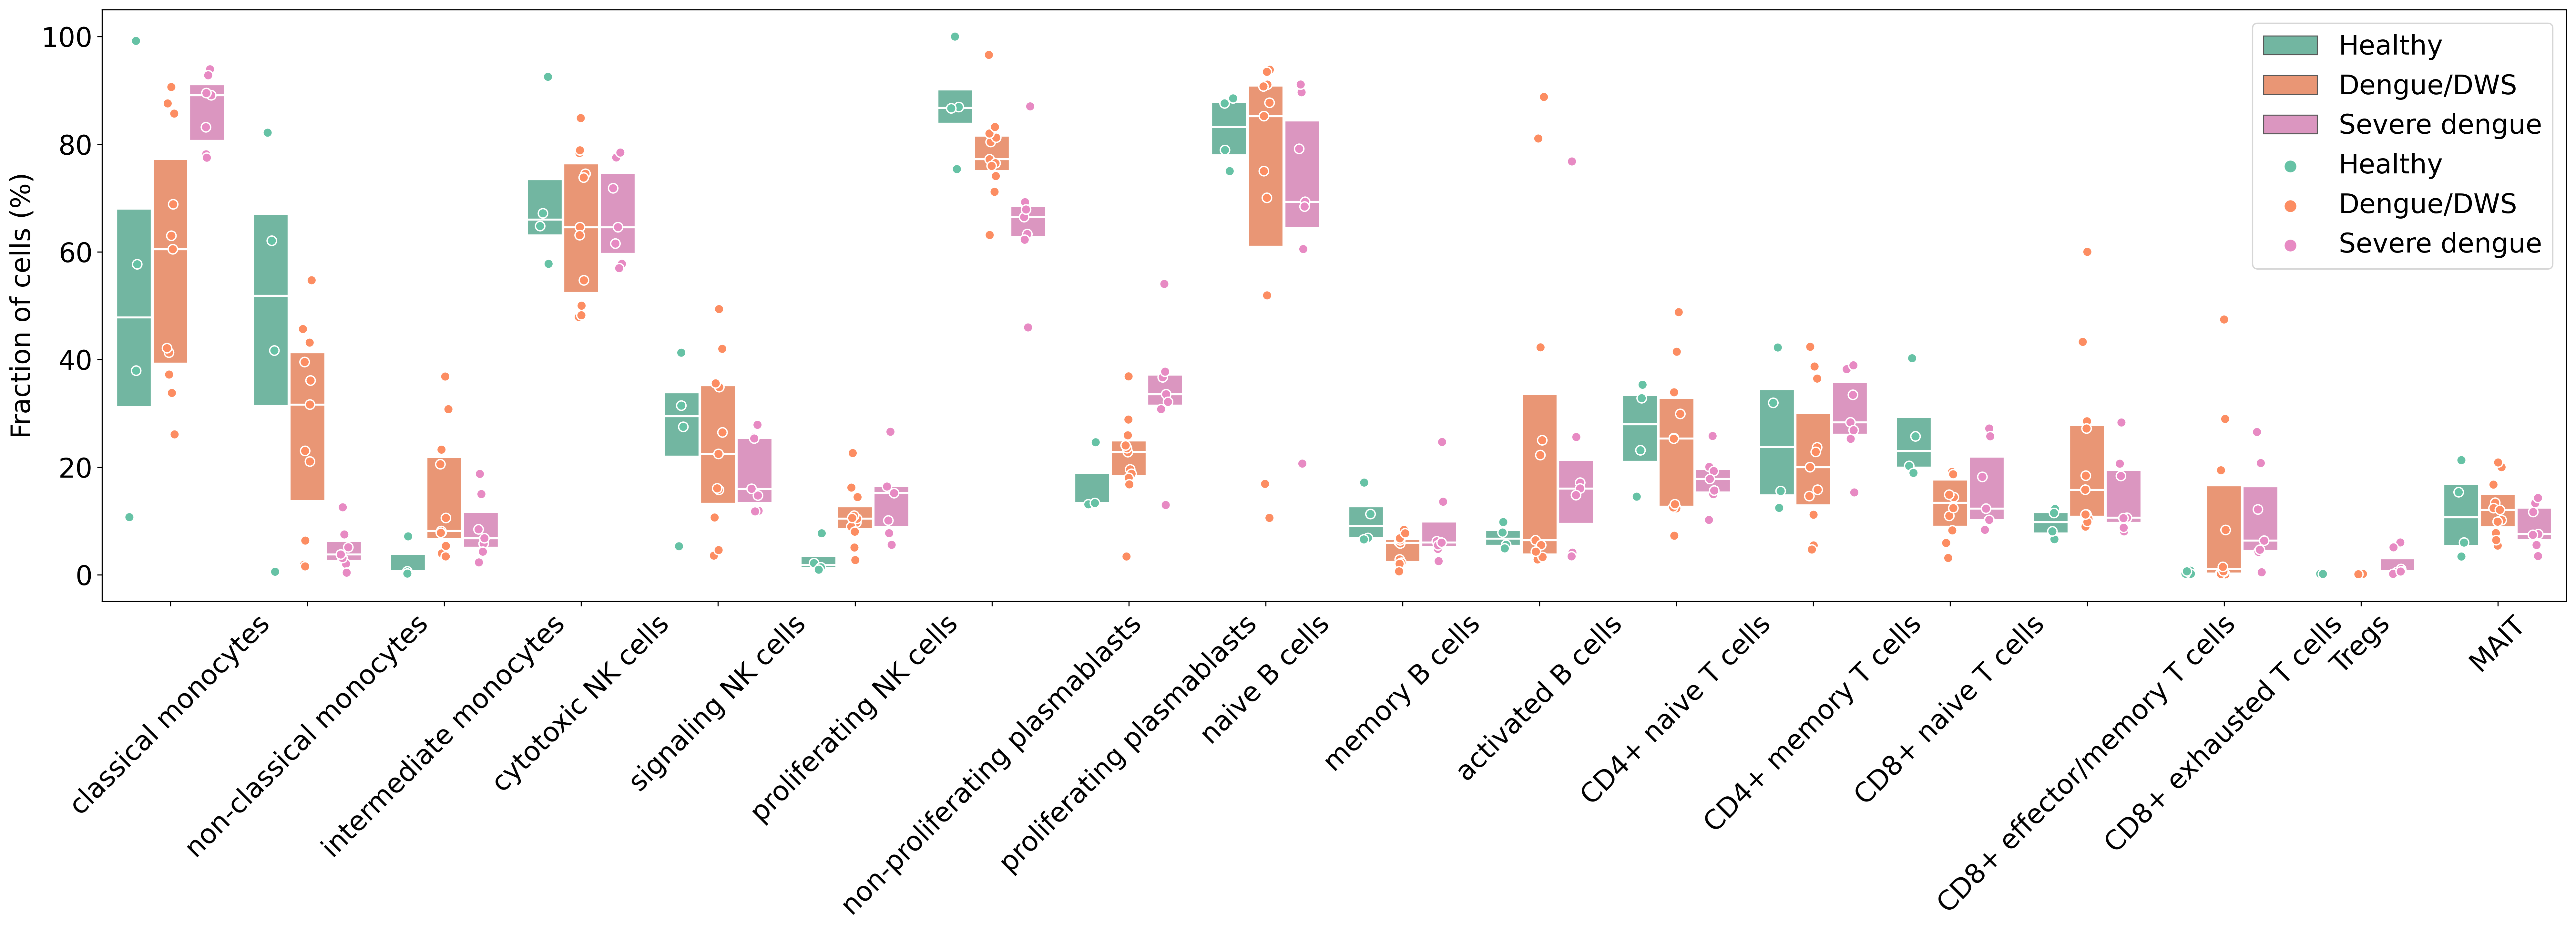

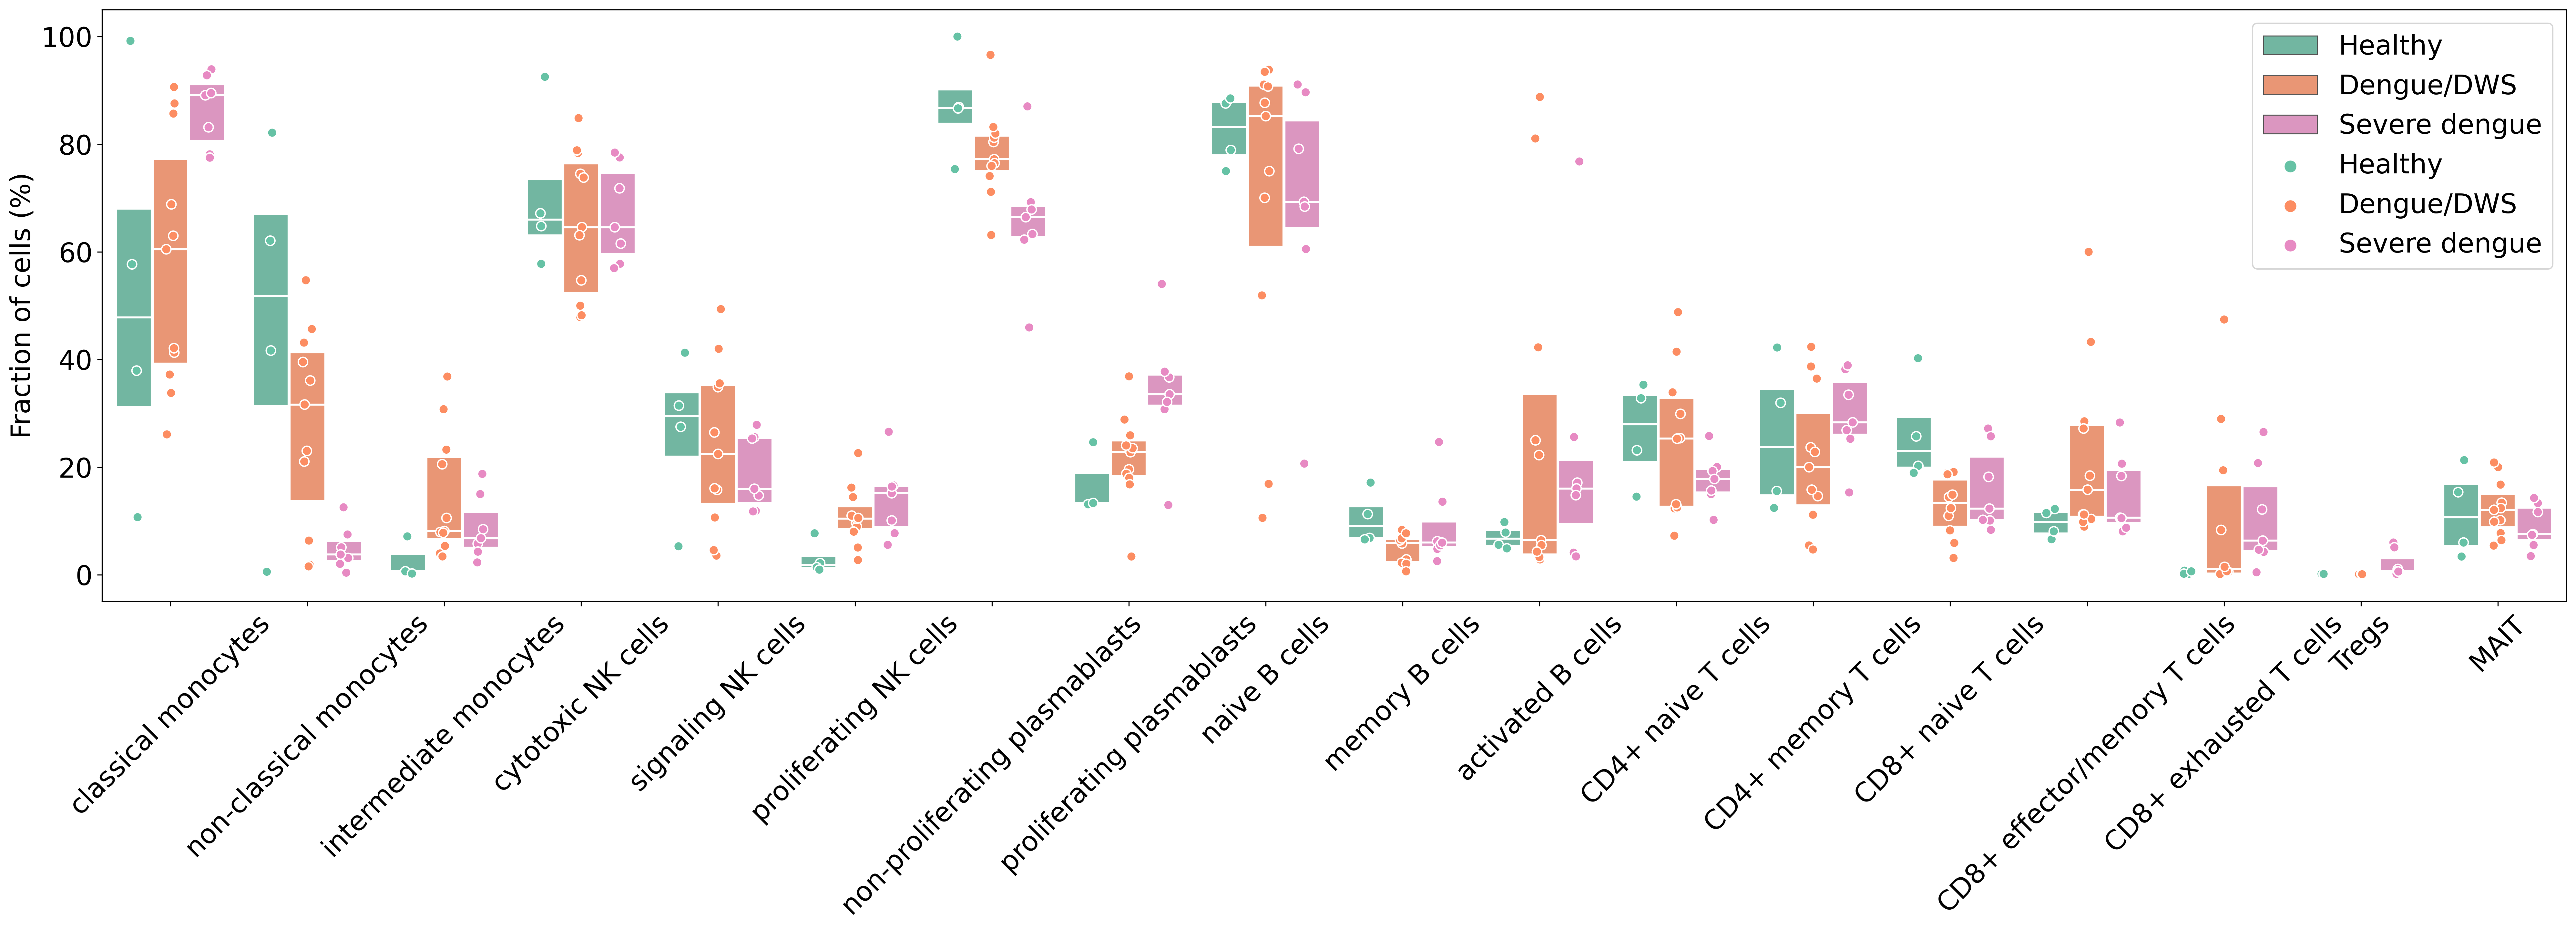

In [75]:
save_figures = '/home/yike/phd/'
cst_order = [ 'classical monocytes',
        'non-classical monocytes',
        'intermediate monocytes',

        'cytotoxic NK cells',
        'signaling NK cells',
        'proliferating NK cells',

        'non-proliferating plasmablasts',
        'proliferating plasmablasts',

        'naive B cells',
        'memory B cells',
        'activated B cells',

        'CD4+ naive T cells',
        'CD4+ memory T cells',

        'CD8+ naive T cells',
        'CD8+ effector/memory T cells',
        'CD8+ exhausted T cells',
        'Tregs',
        'MAIT',]

cell_abundance(df_frac, cst_order, save_figures, '1.png')
cell_abundance(df_frac, cst_order, save_figures, '1.pdf')

In [76]:
df_frac.to_csv(save_figures + 'df_frac_cell_subtype_luca.tsv', sep='\t')

In [79]:
SD = adata_kid[adata_kid.obs['Condition'] == 'S_dengue']
D = adata_kid[adata_kid.obs['Condition'] == 'dengue']

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [ ]:
len(SD.X.toarray().mean(axis=0))

In [ ]:
log2FD = np.log2((SD + 0.1) - (D + 0.1))